In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults, ARIMAResults
from matplotlib.pyplot import acorr
import sys
print sys.version
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
%pylab inline

2.7.11 (default, Dec  5 2015, 14:44:47) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)]
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# first read in data
data = pd.read_csv('http://people.stern.nyu.edu/churvich/Forecasting/Data/Rupee.CSV')
data['Date'] = pd.to_datetime(data.Date)
data.head()

,Date,Rupee
0,2002-07-01,48.86
1,2002-07-02,48.87
2,2002-07-03,48.83
3,2002-07-05,48.86
4,2002-07-08,48.84


## Question 1 - Plot the logs of the Rupee

In [3]:
data['log_rupee'] = [np.log(i) for i in data.Rupee]
data['diff_log_rupee'] = data.log_rupee - data.log_rupee.shift(periods = -1)
data = data.dropna()
print data.head()
print data.tail()

        Date  Rupee  log_rupee  diff_log_rupee
0 2002-07-01  48.86   3.888959       -0.000205
1 2002-07-02  48.87   3.889164        0.000819
2 2002-07-03  48.83   3.888345       -0.000614
3 2002-07-05  48.86   3.888959        0.000409
4 2002-07-08  48.84   3.888550        0.000410
           Date  Rupee  log_rupee  diff_log_rupee
2229 2011-04-01  44.44   3.794140        0.002478
2230 2011-04-04  44.33   3.791662        0.000226
2231 2011-04-05  44.32   3.791436        0.006111
2232 2011-04-06  44.05   3.785325       -0.002268
2233 2011-04-07  44.15   3.787593        0.000906


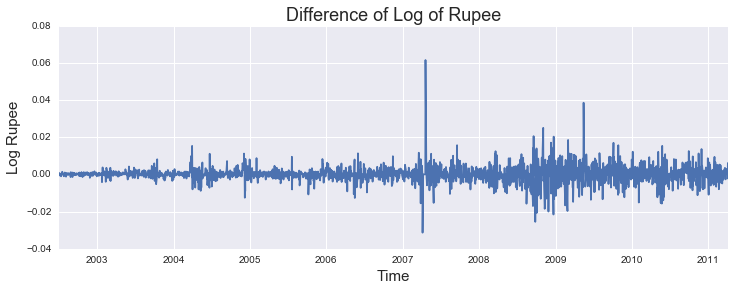

In [4]:
fig, ax = plt.subplots(figsize = (12,4))
plt.plot(data.Date, data.diff_log_rupee)
plt.title('Difference of Log of Rupee', fontsize = 18)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Log Rupee', fontsize = 15)

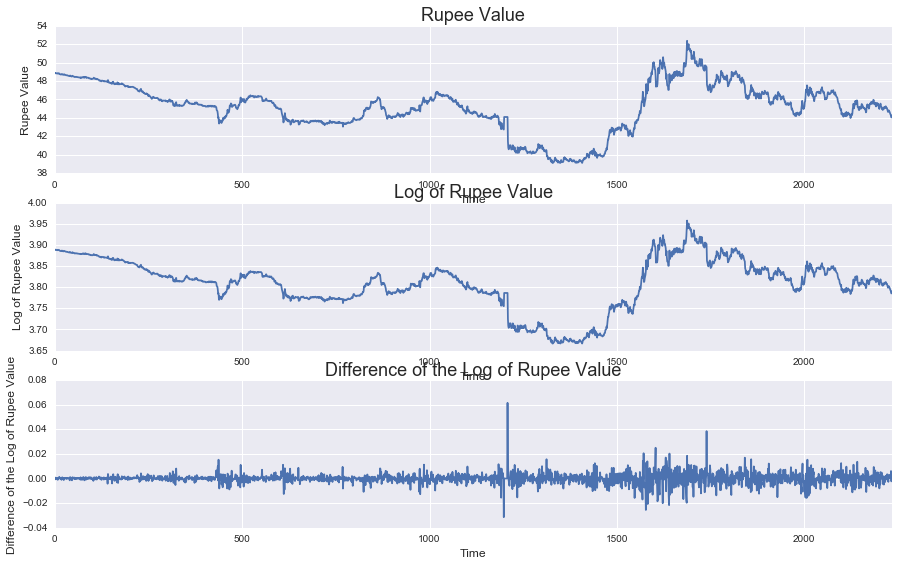

In [5]:
fig, ax = plt.subplots(figsize = (15,9))

plt.subplot(311)
data.Rupee.plot()
plt.title('Rupee Value', fontsize = 18)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Rupee Value', fontsize =12)

plt.subplot(312)
data.log_rupee.plot()
plt.title('Log of Rupee Value', fontsize = 18)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Log of Rupee Value', fontsize =12)

plt.subplot(313)
data.diff_log_rupee.plot()
plt.title('Difference of the Log of Rupee Value', fontsize = 18)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Difference of the Log of Rupee Value', fontsize =12)

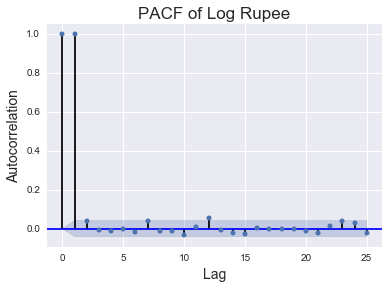

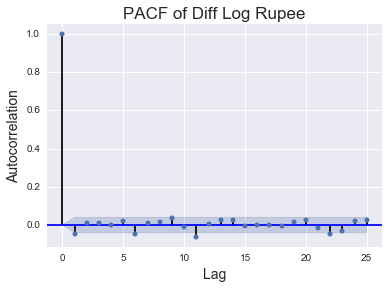

In [6]:
# plot the PACF
plot_pacf(data.log_rupee, lags = 25)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('PACF of Log Rupee', fontsize = 17)

plot_pacf(data.diff_log_rupee, lags = 25)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('PACF of Diff Log Rupee', fontsize = 17)

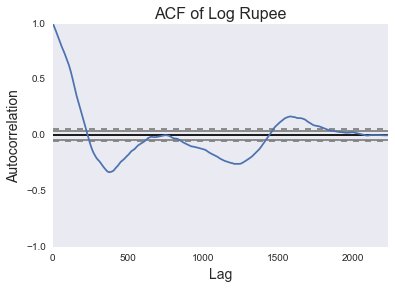

In [7]:
# then plot the ACF of log rupee
autocorrelation_plot(data.log_rupee)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('ACF of Log Rupee', fontsize= 16)

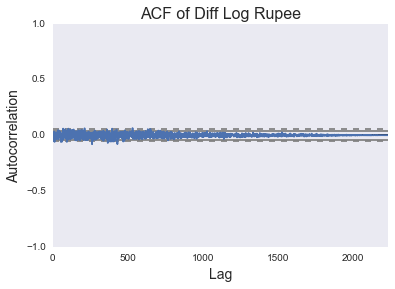

In [8]:
# then plot the ACF of the diff log rupee
autocorrelation_plot(data.diff_log_rupee)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('ACF of Diff Log Rupee', fontsize= 16)

In [9]:
#Perform Dickey-Fuller test:
print 'Results of Dickey-Fuller Test:'
dftest = adfuller(data.diff_log_rupee, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
   dfoutput['Critical Value (%s)'%key] = value
print dfoutput

Results of Dickey-Fuller Test:
Test Statistic                  -49.545412
p-value                           0.000000
# Lags Used                       0.000000
Number of Observations Used    2233.000000
Critical Value (5%)              -2.862835
Critical Value (1%)              -3.433282
Critical Value (10%)             -2.567460
dtype: float64


Based on the results of the Augmented Dickey-Fuller (ADF) test, we can confidently say that this time series is stationary. We can conclude this because the ADF Test Statistic of -49 is less than the critical value at 1%, meaning that we are 99% confident that the time series is stationary.

## Question 2 - Model Selection

In [10]:
ararray = (data.log_rupee.dropna().as_matrix())

p=0
q=0
d=1
pdq=[]
aic=[]

for p in range(6):
    for q in range(6):
        try:
            model = ARIMA(ararray, (p,d,q)).fit()
            x = model.aic
            x1 = (p,d,q)
            
            #print (x1, x)
            aic.append(x)
            pdq.append(x1)
        except:
            pass
                  
keys = pdq
values = aic
d = dict(zip(keys, values))

minaic=min(d, key=d.get)

for i in range(3):
    p=minaic[0]
    d=minaic[1]
    q=minaic[2]

print 'The model with the lowest AIC score of %s' % np.round(x,4)
print 'Best described with an ARIMA(',p,d,q,') model'

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

The model with the lowest AIC score of -17756.0793
Best described with an ARIMA( 2 1 2 ) model


In [11]:
model = ARIMA(ararray, (2,1,2)).fit()
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2233
Model:                 ARIMA(2, 1, 2)   Log Likelihood                8885.699
Method:                       css-mle   S.D. of innovations              0.005
Date:                Mon, 02 May 2016   AIC                         -17759.398
Time:                        16:52:59   BIC                         -17725.131
Sample:                             1   HQIC                        -17746.886
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -4.547e-05   9.57e-05     -0.475      0.635        -0.000     0.000
ar.L1.D.y      0.6816      0.096      7.097      0.000         0.493     0.870
ar.L2.D.y     -0.8652      0.048    -17.853      0.0

In [12]:
len(model.predict())

2233

In [13]:
#data.diff_log_rupee = data.diff_log_rupee[0:-1]
len(data)

2234

In [14]:
# calculate the residuals (or errors)
prediction = pd.DataFrame(data.log_rupee[1:])
prediction['predict'] = model.predict()
prediction['residuals'] = prediction.log_rupee - prediction.predict

In [15]:
prediction.head()

,log_rupee,predict,residuals
1,3.889164,-0.000045,3.889209
2,3.888345,-0.000054,3.888399
3,3.888959,-0.000017,3.888977
4,3.888550,-0.000064,3.888614
5,3.888140,-0.000051,3.888191


In [16]:
import statsmodels.stats.diagnostic
from pypr.stattest.ljungbox import *
import scipy.stats

In [17]:
# predict our ARIMA(0,1,1) model
pred = model.predict()
# then use ljung-box on our prediction
box = statsmodels.stats.diagnostic.acorr_ljungbox(pred, lags=25, boxpierce=False)
box

(array([  166.87770408,  1189.85410389,  2290.69744441,  2317.93294241,
         3360.3113114 ,  3645.23748009,  3898.33490814,  4534.67904465,
         4545.04341375,  4909.32331702,  5149.62018934,  5179.0350166 ,
         5476.70066545,  5527.5500419 ,  5630.39570743,  5809.01355899,
         5809.01957945,  5948.95997826,  6010.69866737,  6037.24901968,
         6139.97246748,  6145.76975423,  6194.96695471,  6242.51462335,
         6243.1593458 ]),
 array([  3.55748679e-038,   4.23120634e-259,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+

The results of the Box-Ljung test show numerous p-values above 0.05, meaning that the model accurately describes the time series

In [18]:
# calculate 1 step ahead forecast
numofsteps = 1
stepahead = model.forecast(numofsteps)[0]
ferrors = model.forecast(numofsteps)[2]

print'%s Step ahead forecast value is:' % numofsteps, np.exp(stepahead)
print '%s Step ahead 95 percent CI is:' % numofsteps, np.exp(ferrors)

1 Step ahead forecast value is: [ 44.14920091]
1 Step ahead 95 percent CI is: [[ 43.75941243  44.54246145]]


## Question 3 - Plot ACF and PACF of Residuals

In [19]:
data = data[1:]
data = data.reset_index()
data['prediction'] = model.predict()
data['resid'] = data.log_rupee - data.prediction
data['sq_resid'] = [i**2 for i in data.resid]

In [20]:
data.head()

,index,Date,Rupee,log_rupee,diff_log_rupee,prediction,resid,sq_resid
0,1,2002-07-02,48.87,3.889164,0.000819,-0.000045,3.889209,15.125948
1,2,2002-07-03,48.83,3.888345,-0.000614,-0.000054,3.888399,15.119647
2,3,2002-07-05,48.86,3.888959,0.000409,-0.000017,3.888977,15.124139
3,4,2002-07-08,48.84,3.888550,0.000410,-0.000064,3.888614,15.121318
4,5,2002-07-09,48.82,3.888140,0.000000,-0.000051,3.888191,15.118029


In [21]:
# merged.residuals.plot()
# plt.title('Rupee Residuals')
# plt.xlabel('Time')
# plt.ylabel('Residual Value')

In [22]:
# merged.sq_resid.plot()
# plt.title('Squared Residuals of the Rupee')
# plt.ylabel('Squared Residual Value')
# plt.xlabel('Time')

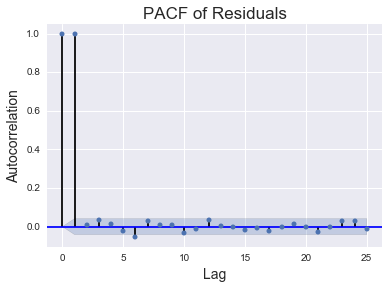

In [23]:
# then plot the PACF and ACF of the residuals
# first, the PACF

plot_pacf(data.resid, lags = 25)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('PACF of Residuals', fontsize = 17)


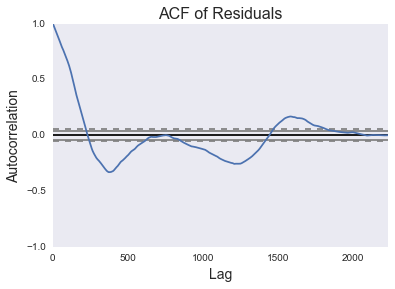

In [24]:
# then plot the ACF of log rupee
autocorrelation_plot(data.resid)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('ACF of Residuals', fontsize= 16)

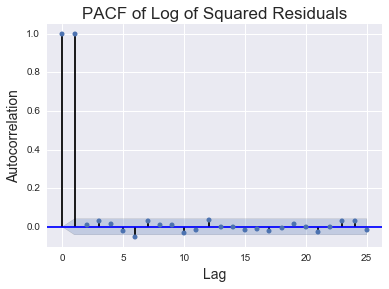

In [25]:
# then plot the PACF and ACF of the squared residuals
# first, the PACF

plot_pacf(data.sq_resid, lags = 25)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('PACF of Log of Squared Residuals', fontsize = 17)

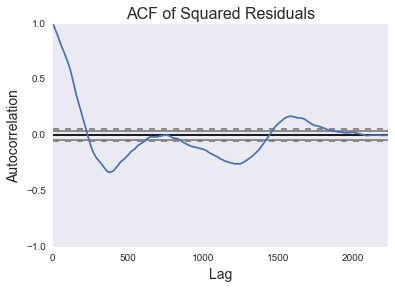

In [26]:
# then plot the ACF of log rupee
autocorrelation_plot(data.sq_resid)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('ACF of Squared Residuals', fontsize= 16)

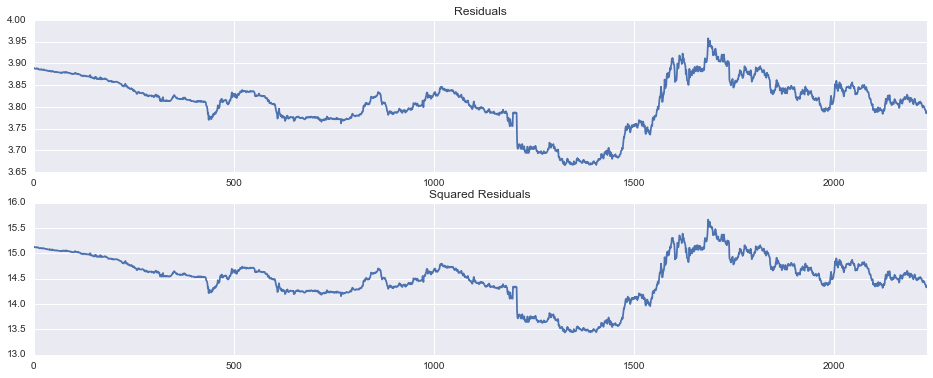

In [27]:
# plot residuals and squared residuals
fig, ax = plt.subplots(figsize = (16,6))

plt.subplot(211)
data.resid.plot()
plt.title('Residuals')

plt.subplot(212)
data.sq_resid.plot()
plt.title('Squared Residuals')

## Question 4 - Log Likelihood

In [28]:
from arch import arch_model

In [29]:
am = arch_model(data.sq_resid, q=1)
res = am.fit()
res.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 209.057714999
Iteration:      2,   Func. Count:     19,   Neg. LLF: 166.408673181
Iteration:      3,   Func. Count:     30,   Neg. LLF: 166.181069333
Iteration:      4,   Func. Count:     37,   Neg. LLF: 99.8958955883
Iteration:      5,   Func. Count:     44,   Neg. LLF: -103.014200752
Iteration:      6,   Func. Count:     55,   Neg. LLF: -104.005217988
Iteration:      7,   Func. Count:     66,   Neg. LLF: -104.174766213
Iteration:      8,   Func. Count:     76,   Neg. LLF: -104.246175071
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -104.24617835
            Iterations: 12
            Function evaluations: 76
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               sq_resid   R-squared:                      -0.022
Mean Model:             Constant Mean   Adj. R-squared:                 -0.022
Vol Model:                      GARCH   Log-Likelihood:                104.246
Distribution:                  Normal   AIC:                          -200.492
Method:            Maximum Likelihood   BIC:                          -177.648
                                        No. Observations:                 2233
Date:                Mon, May 02 2016   Df Residuals:                     2229
Time:                        16:53:02   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            14.5777  9.108e-05  1.600e+05      0.000       [ 14.577, 14.578]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      2.3288e-03  3.652e-08  6.377e+04      0.000   [2.329e-03,2.329e-03]
alpha[1]       0.4595  4.588e-04   1001.618      0.000       [  0.459,  0.460]
beta[1]        0.4683  7.487e-04    625.394      0.000       [  0.467,  0.470]
==============================================================================

Covariance estimator: robust
"""

In [30]:
my_list = []

for i in range(11):
    am = arch_model(data.sq_resid, q=i)
    res = am.fit()
    my_list.append((res.loglikelihood,res.aic,i))

log_like = pd.DataFrame(my_list, columns = ['Log Likelihood','AIC','Lagged Volatility'])
log_like

Iteration:      1,   Func. Count:      5,   Neg. LLF: 801.15591241
Iteration:      2,   Func. Count:     16,   Neg. LLF: 785.372465717
Iteration:      3,   Func. Count:     22,   Neg. LLF: 495.020359593
Iteration:      4,   Func. Count:     29,   Neg. LLF: 473.155703311
Iteration:      5,   Func. Count:     35,   Neg. LLF: 432.624910062
Iteration:      6,   Func. Count:     40,   Neg. LLF: 299.915418307
Iteration:      7,   Func. Count:     50,   Neg. LLF: 298.292440272
Iteration:      8,   Func. Count:     56,   Neg. LLF: 247.988510946
Iteration:      9,   Func. Count:     61,   Neg. LLF: -162.676983744
Iteration:     10,   Func. Count:     71,   Neg. LLF: -163.343974534
Iteration:     11,   Func. Count:     76,   Neg. LLF: -183.600827461
Iteration:     12,   Func. Count:     82,   Neg. LLF: -191.344511556
Iteration:     13,   Func. Count:     92,   Neg. LLF: -191.428795884
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -191.4287965

,Log Likelihood,AIC,Lagged Volatility
0,191.428797,-376.857593,0
1,104.246178,-200.492357,1
2,190.016218,-370.032435,2
3,179.793008,-347.586016,3
4,118.031407,-222.062814,4
5,248.744781,-481.489562,5
6,156.627084,-295.254167,6
7,250.717251,-481.434501,7
8,248.105205,-474.210410,8
9,240.654102,-457.308204,9


In [31]:
arch_want = pd.DataFrame(my_list,columns = ['AIC','Log Likelihood','Lagged Volatility (Q)'])
arch_want

,AIC,Log Likelihood,Lagged Volatility (Q)
0,191.428797,-376.857593,0
1,104.246178,-200.492357,1
2,190.016218,-370.032435,2
3,179.793008,-347.586016,3
4,118.031407,-222.062814,4
5,248.744781,-481.489562,5
6,156.627084,-295.254167,6
7,250.717251,-481.434501,7
8,248.105205,-474.210410,8
9,240.654102,-457.308204,9


In [32]:
my_list = []

for i in range(11):
    am = arch_model(data.resid, q=i, vol='GARCH')
    res = am.fit()
    my_list.append((res.loglikelihood,res.aic,i))

log_like2 = pd.DataFrame(my_list, columns = ['Log Likelihood','AIC','Lagged Volatility'])
log_like2

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3728.68299826
Iteration:      2,   Func. Count:     18,   Neg. LLF: -3760.18516446
Iteration:      3,   Func. Count:     29,   Neg. LLF: -3760.24035918
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3760.24032647
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: -4318.83182853
Iteration:      2,   Func. Count:     22,   Neg. LLF: -4367.16695318
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4367.16697775
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      7,   Neg. LLF: -4305.47533073
Iteration:      2,   Func. Count:     24,   Neg. LLF: -4352.60000414
Iteration:      3,   Func. Count:     37,   Neg. LLF: -4352.61075612
Iteration:      4,  

,Log Likelihood,AIC,Lagged Volatility
0,3760.240326,-7514.480653,0
1,4367.166978,-8726.333956,1
2,4359.000007,-8708.000014,2
3,4339.321093,-8666.642186,3
4,4362.495360,-8710.990719,4
5,4315.886577,-8615.773153,5
6,4305.211903,-8592.423806,6
7,4295.052231,-8570.104462,7
8,4285.247956,-8548.495912,8
9,4275.728508,-8527.457016,9


In [33]:
am = arch_model(data.resid, q=2, vol='GARCH')
res = am.fit()
res.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: -4305.47533073
Iteration:      2,   Func. Count:     24,   Neg. LLF: -4352.60000414
Iteration:      3,   Func. Count:     37,   Neg. LLF: -4352.61075612
Iteration:      4,   Func. Count:     54,   Neg. LLF: -4352.61109257
Iteration:      5,   Func. Count:     64,   Neg. LLF: -4355.9539952
Iteration:      6,   Func. Count:     78,   Neg. LLF: -4358.3992511
Iteration:      7,   Func. Count:     92,   Neg. LLF: -4358.99931562
Iteration:      8,   Func. Count:    108,   Neg. LLF: -4358.99998271
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4359.00000715
            Iterations: 12
            Function evaluations: 108
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  resid   R-squared:                      -0.025
Mean Model:             Constant Mean   Adj. R-squared:                 -0.025
Vol Model:                      GARCH   Log-Likelihood:                4359.00
Distribution:                  Normal   AIC:                          -8708.00
Method:            Maximum Likelihood   BIC:                          -8679.44
                                        No. Observations:                 2233
Date:                Mon, May 02 2016   Df Residuals:                     2228
Time:                        16:53:02   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             3.8182  1.119e-06  3.413e+06      0.000       [  3.818,  3.818]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      6.8032e-05  6.296e-11  1.080e+06      0.000   [6.803e-05,6.803e-05]
alpha[1]       0.1992  7.332e-05   2716.490      0.000       [  0.199,  0.199]
beta[1]        0.3884      0.389      0.998      0.318       [ -0.374,  1.151]
beta[2]        0.3884      0.393      0.989      0.322       [ -0.381,  1.158]
==============================================================================

Covariance estimator: robust
"""

In [34]:
am = arch_model(data.resid, q=1)
res = am.fit()
print res.aic
print res.loglikelihood

Iteration:      1,   Func. Count:      6,   Neg. LLF: -4318.83182853
Iteration:      2,   Func. Count:     22,   Neg. LLF: -4367.16695318
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4367.16697775
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2
-8726.33395551
4367.16697775


In [35]:
am = arch_model(data.resid, q=2, vol='GARCH')
garch = am.fit()
print garch.aic
print garch.loglikelihood

Iteration:      1,   Func. Count:      7,   Neg. LLF: -4305.47533073
Iteration:      2,   Func. Count:     24,   Neg. LLF: -4352.60000414
Iteration:      3,   Func. Count:     37,   Neg. LLF: -4352.61075612
Iteration:      4,   Func. Count:     54,   Neg. LLF: -4352.61109257
Iteration:      5,   Func. Count:     64,   Neg. LLF: -4355.9539952
Iteration:      6,   Func. Count:     78,   Neg. LLF: -4358.3992511
Iteration:      7,   Func. Count:     92,   Neg. LLF: -4358.99931562
Iteration:      8,   Func. Count:    108,   Neg. LLF: -4358.99998271
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4359.00000715
            Iterations: 12
            Function evaluations: 108
            Gradient evaluations: 8
-8708.00001429
4359.00000715


In [36]:
print 'ARCH Model, Q=1 (Best):'
print 'ARCH with Q=1 AIC is %s' %res.aic
print 'ARCH with Q=1 Log Likelihood is %s' % res.loglikelihood
print ''
print 'GARCH Model, Q=2:'
print 'GARCH AIC is %s' % garch.aic
print 'GARCH Log Likelihood is %s' % garch.loglikelihood

ARCH Model, Q=1 (Best):
ARCH with Q=1 AIC is -8726.33395551
ARCH with Q=1 Log Likelihood is 4367.16697775

GARCH Model, Q=2:
GARCH AIC is -8708.00001429
GARCH Log Likelihood is 4359.00000715


Consequently, we would select the ARCH model with Q=1 because its AIC score is lower than that of the GARCH model at Q=2

## Question 5 - Forecast One-Step Ahead

In [37]:
my_list = []

for i in range(11):
    am = arch_model(data.log_rupee, q=i, vol='GARCH')
    res = am.fit()
    my_list.append((res.loglikelihood,res.aic,i))

log_like3 = pd.DataFrame(my_list, columns = ['Log Likelihood','AIC','Lagged Volatility'])
log_like3

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3728.7120082
Iteration:      2,   Func. Count:     18,   Neg. LLF: -3760.26306992
Iteration:      3,   Func. Count:     29,   Neg. LLF: -3760.2766875
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3760.27665479
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: -4319.12369192
Iteration:      2,   Func. Count:     22,   Neg. LLF: -4367.62864854
Iteration:      3,   Func. Count:     38,   Neg. LLF: -4367.63849381
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4367.63851841
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      7,   Neg. LLF: -4305.69422947
Iteration:      2,   Func. Count:     24,   Neg. LLF: -4352.96949913
Positive directional d

,Log Likelihood,AIC,Lagged Volatility
0,3760.276655,-7514.553310,0
1,4367.638518,-8727.277037,1
2,4352.969525,-8695.939050,2
3,4339.535706,-8667.071411,3
4,4327.397533,-8640.795066,4
5,4316.062478,-8616.124957,5
6,4305.503450,-8593.006900,6
7,4295.236631,-8570.473262,7
8,4285.421736,-8548.843472,8
9,4275.896534,-8527.793068,9


In [38]:
# garch model
am2 = arch_model(data.log_rupee, q=2, vol='GARCH')
garch = am2.fit()
print garch.aic
print garch.loglikelihood

Iteration:      1,   Func. Count:      7,   Neg. LLF: -4305.69422947
Iteration:      2,   Func. Count:     24,   Neg. LLF: -4352.96949913
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4352.96952492
            Iterations: 6
            Function evaluations: 24
            Gradient evaluations: 2
-8695.93904984
4352.96952492


In [39]:
# arch model
am3 = arch_model(data.log_rupee, q=1)
res = am3.fit()
print res.aic
print res.loglikelihood

Iteration:      1,   Func. Count:      6,   Neg. LLF: -4319.12369192
Iteration:      2,   Func. Count:     22,   Neg. LLF: -4367.62864854
Iteration:      3,   Func. Count:     38,   Neg. LLF: -4367.63849381
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4367.63851841
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 3
-8727.27703682
4367.63851841


In [40]:
print 'ARCH Model, Q=1 (Best):'
print 'ARCH with Q=1 AIC is %s' %res.aic
print 'ARCH with Q=1 Log Likelihood is %s' % res.loglikelihood
print ''
print 'GARCH Model, Q=2:'
print 'GARCH AIC is %s' % garch.aic
print 'GARCH Log Likelihood is %s' % garch.loglikelihood

ARCH Model, Q=1 (Best):
ARCH with Q=1 AIC is -8727.27703682
ARCH with Q=1 Log Likelihood is 4367.63851841

GARCH Model, Q=2:
GARCH AIC is -8695.93904984
GARCH Log Likelihood is 4352.96952492


In [41]:
# calculate one step ahead forecast
# remember that since we are forecasting the logs, we need to take the exponent to convert back to actual rupee values
print 'Our one step ahead forecast using the ARCH(1,1) model with Q=1 is %s' % np.exp(res.forecast())

Our one step ahead forecast using the ARCH(1,1) model with Q=1 is             h.1
0     45.528196
1     45.528196
2     45.528196
3     45.528196
4     45.528196
5     45.528196
6     45.528196
7     45.528196
8     45.528196
9     45.528196
10    45.528196
11    45.528196
12    45.528196
13    45.528196
14    45.528196
15    45.528196
16    45.528196
17    45.528196
18    45.528196
19    45.528196
20    45.528196
21    45.528196
22    45.528196
23    45.528196
24    45.528196
25    45.528196
26    45.528196
27    45.528196
28    45.528196
29    45.528196
...         ...
2203  45.528196
2204  45.528196
2205  45.528196
2206  45.528196
2207  45.528196
2208  45.528196
2209  45.528196
2210  45.528196
2211  45.528196
2212  45.528196
2213  45.528196
2214  45.528196
2215  45.528196
2216  45.528196
2217  45.528196
2218  45.528196
2219  45.528196
2220  45.528196
2221  45.528196
2222  45.528196
2223  45.528196
2224  45.528196
2225  45.528196
2226  45.528196
2227  45.528196
2228  45.528196
2229  

In [42]:
arch_pred = np.exp(res.forecast())[0:1]
arima_pred = np.exp(stepahead)

In [43]:
float(arch_pred.loc[0])/arima_pred-1

array([ 0.03123488])

## Question 6 - Plotting Conditional Variances

In [44]:
cond_var = res.conditional_volatility**2

# add to our big dataframe
data['cond_var'] = cond_var
data.head()

,index,Date,Rupee,log_rupee,diff_log_rupee,prediction,resid,sq_resid,cond_var
0,1,2002-07-02,48.87,3.889164,0.000819,-0.000045,3.889209,15.125948,0.005975
1,2,2002-07-03,48.83,3.888345,-0.000614,-0.000054,3.888399,15.119647,0.005732
2,3,2002-07-05,48.86,3.888959,0.000409,-0.000017,3.888977,15.124139,0.005520
3,4,2002-07-08,48.84,3.888550,0.000410,-0.000064,3.888614,15.121318,0.005371
4,5,2002-07-09,48.82,3.888140,0.000000,-0.000051,3.888191,15.118029,0.005244


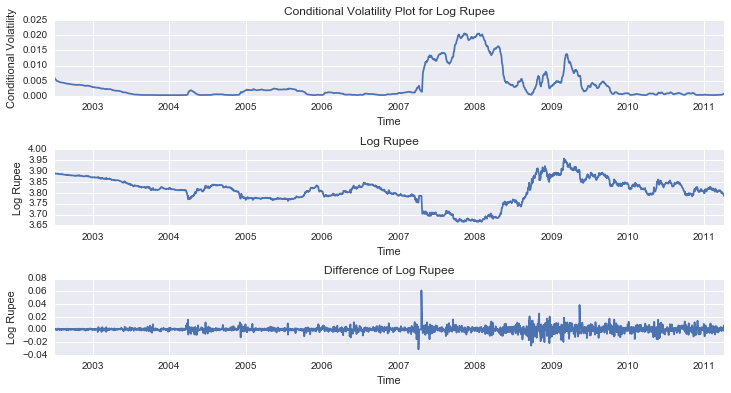

In [45]:
fig, ax = plt.subplots(figsize = (12,6))
fig.subplots_adjust(hspace=.7)

plt.subplot(311)
plt.plot(data.Date, data.cond_var)
plt.title('Conditional Volatility Plot for Log Rupee')
plt.xlabel('Time')
plt.ylabel('Conditional Volatility')

plt.subplot(312)
plt.plot(data.Date, data.log_rupee)
plt.title('Log Rupee')
plt.xlabel('Time')
plt.ylabel('Log Rupee')

plt.subplot(313)
plt.plot(data.Date, data.diff_log_rupee)
plt.title('Difference of Log Rupee')
plt.xlabel('Time')
plt.ylabel('Log Rupee')

In [46]:
conf_ints = np.exp(res.conf_int())
conf_ints

,lower,upper
mu,45.528093,45.528299
omega,1.000068,1.000068
alpha[1],1.221264,1.221541
beta[1],2.181248,2.181693


In [47]:
# alpha is the 95% confidence interval
# beta is the 90% confidence interval

In [48]:
np.exp(res.forecast(align='target', start=0)).ix[:3]

,h.1
0,NaN
1,45.528196
2,45.528196
3,45.528196


In [49]:
data.head()

,index,Date,Rupee,log_rupee,diff_log_rupee,prediction,resid,sq_resid,cond_var
0,1,2002-07-02,48.87,3.889164,0.000819,-0.000045,3.889209,15.125948,0.005975
1,2,2002-07-03,48.83,3.888345,-0.000614,-0.000054,3.888399,15.119647,0.005732
2,3,2002-07-05,48.86,3.888959,0.000409,-0.000017,3.888977,15.124139,0.005520
3,4,2002-07-08,48.84,3.888550,0.000410,-0.000064,3.888614,15.121318,0.005371
4,5,2002-07-09,48.82,3.888140,0.000000,-0.000051,3.888191,15.118029,0.005244


In [50]:
data['arch_resid'] = np.exp(data.log_rupee) + res.resid
data['upper_bound'] = data.arch_resid +  conf_ints.loc['alpha[1]','upper']
data['lower_bound'] = data.arch_resid - conf_ints.loc['alpha[1]','lower']
data.head()

,index,Date,Rupee,log_rupee,diff_log_rupee,prediction,resid,sq_resid,cond_var,arch_resid,upper_bound,lower_bound
0,1,2002-07-02,48.87,3.889164,0.000819,-0.000045,3.889209,15.125948,0.005975,48.940832,50.162372,47.719567
1,2,2002-07-03,48.83,3.888345,-0.000614,-0.000054,3.888399,15.119647,0.005732,48.900013,50.121554,47.678749
2,3,2002-07-05,48.86,3.888959,0.000409,-0.000017,3.888977,15.124139,0.005520,48.930627,50.152168,47.709363
3,4,2002-07-08,48.84,3.888550,0.000410,-0.000064,3.888614,15.121318,0.005371,48.910218,50.131758,47.688953
4,5,2002-07-09,48.82,3.888140,0.000000,-0.000051,3.888191,15.118029,0.005244,48.889808,50.111349,47.668544


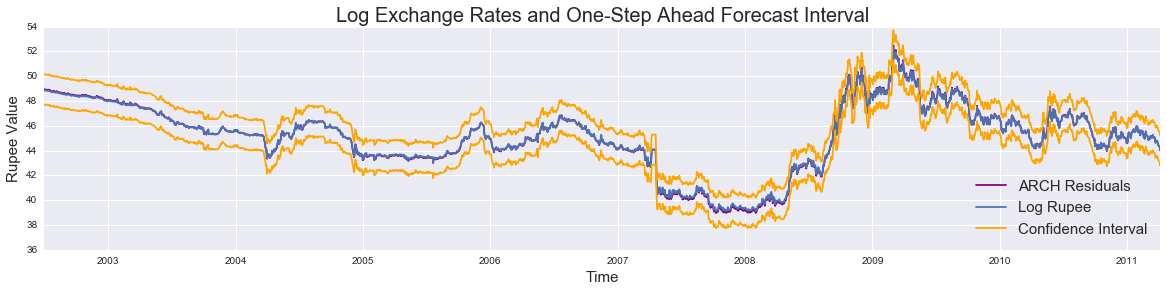

In [51]:
fig, ax = plt.subplots(figsize=(20,4))

plt.subplot(111)
plt.plot(data.Date, data.arch_resid, label = 'ARCH Residuals', color = 'purple')
plt.plot(data.Date, np.exp(data.log_rupee), label = 'Log Rupee')
plt.plot(data.Date, data.upper_bound, label = 'Confidence Interval', color = 'orange')
plt.plot(data.Date, data.lower_bound, color = 'orange', label = '')
plt.title('Log Exchange Rates and One-Step Ahead Forecast Interval', fontsize = 20)
plt.legend(loc = 4, fontsize = 15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Rupee Value', fontsize = 15)

As we can see, the ARCH model failed to do a good job of predicting periods of high volatility, such as the financial crisis seen in 2008. Otherwise, it actually did pretty well!

## Question 8 - Compute Residuals for ARIMA/ARCH Model

In [52]:
data.head()

,index,Date,Rupee,log_rupee,diff_log_rupee,prediction,resid,sq_resid,cond_var,arch_resid,upper_bound,lower_bound
0,1,2002-07-02,48.87,3.889164,0.000819,-0.000045,3.889209,15.125948,0.005975,48.940832,50.162372,47.719567
1,2,2002-07-03,48.83,3.888345,-0.000614,-0.000054,3.888399,15.119647,0.005732,48.900013,50.121554,47.678749
2,3,2002-07-05,48.86,3.888959,0.000409,-0.000017,3.888977,15.124139,0.005520,48.930627,50.152168,47.709363
3,4,2002-07-08,48.84,3.888550,0.000410,-0.000064,3.888614,15.121318,0.005371,48.910218,50.131758,47.688953
4,5,2002-07-09,48.82,3.888140,0.000000,-0.000051,3.888191,15.118029,0.005244,48.889808,50.111349,47.668544


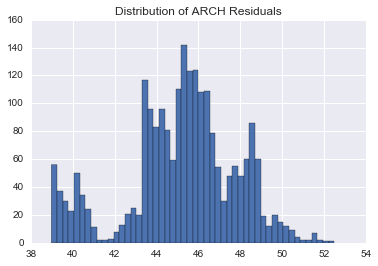

In [53]:
data.arch_resid.hist(bins = 50)
plt.title('Distribution of ARCH Residuals')

The distribution displays strong leptokurtosis (heavy tails) and do not appear normally distributed

In [54]:
data['fail_upper'] = data.arch_resid > data.upper_bound
data['fail_lower'] = data.arch_resid < data.lower_bound

In [55]:
data.head()

,index,Date,Rupee,log_rupee,diff_log_rupee,prediction,resid,sq_resid,cond_var,arch_resid,upper_bound,lower_bound,fail_upper,fail_lower
0,1,2002-07-02,48.87,3.889164,0.000819,-0.000045,3.889209,15.125948,0.005975,48.940832,50.162372,47.719567,False,False
1,2,2002-07-03,48.83,3.888345,-0.000614,-0.000054,3.888399,15.119647,0.005732,48.900013,50.121554,47.678749,False,False
2,3,2002-07-05,48.86,3.888959,0.000409,-0.000017,3.888977,15.124139,0.005520,48.930627,50.152168,47.709363,False,False
3,4,2002-07-08,48.84,3.888550,0.000410,-0.000064,3.888614,15.121318,0.005371,48.910218,50.131758,47.688953,False,False
4,5,2002-07-09,48.82,3.888140,0.000000,-0.000051,3.888191,15.118029,0.005244,48.889808,50.111349,47.668544,False,False


In [56]:
fail = len(data[data.fail_upper == True])
print 'The forecast failed %s percent of the time' % fail

The forecast failed 0 percent of the time
